## 6.3 IRT(Item Response Theory)によるテスト評価

In [1]:
# ライブラリの更新・追加導入
#!pip install 'pymc>=5.9' | tail -n 1
#!pip install numpyro | tail -n 1

<a href="https://colab.research.google.com/github/makaishi2/python_bayes_intro/blob/main/notebooks/6_3_IRT%E3%81%AB%E3%82%88%E3%82%8B%E3%83%86%E3%82%B9%E3%83%88%E7%B5%90%E6%9E%9C%E8%A9%95%E4%BE%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

参考リンク

[試験の数理 その１（問題設定とデータの生成）](https://qiita.com/takuyakubo/items/43d56725952e67032b49)

### 共通処理

In [2]:
#%matplotlib inline
# 日本語化ライブラリ導入
#!pip install japanize-matplotlib | tail -n 1

In [3]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

In [4]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.11.0
Running on ArViz v0.17.1


### 6.3.1 IRT(Item Response Theory)とは

#### シグモイド関数の定義

In [5]:
def f(x):
    return 1/(1 + np.exp(-x))

#### 項目特性曲線の描画

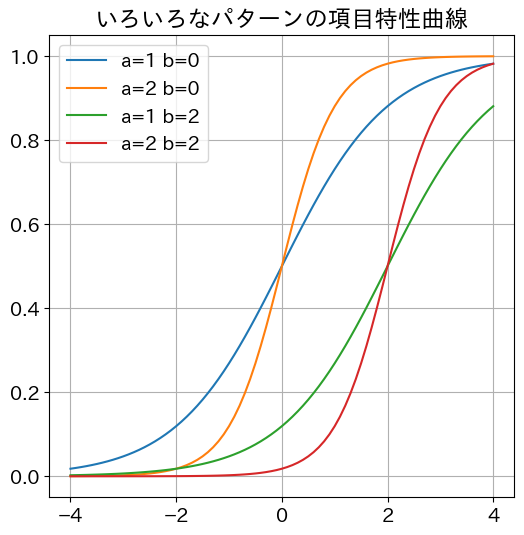

,a(識別力),b(困難度),f(1),f(2)
問題1,1.000,0.000,0.731,0.881
問題2,2.000,0.000,0.881,0.982
問題3,1.000,2.000,0.269,0.500
問題4,2.000,2.000,0.119,0.500


In [6]:
params = [
    [1, 0], [2, 0], [1, 2], [2, 2]
]

x = np.arange(-4, 4.1, 0.1)

vals = np.zeros((0, 4))

for a,b in params:
    y = f(a*(x - b))
    y1 = f(a*(1-b))
    y2 = f(a*(2-b))
    vals = np.vstack([vals, [a,b,y1, y2]])
    #print(f'a={a} b={b} f(1)={y1:.02f} f(2)={y2:.02f}')
    plt.plot(x, y, label=f'a={a} b={b}')
plt.legend()
plt.title('いろいろなパターンの項目特性曲線')
plt.show()

df = pd.DataFrame(vals, columns=['a(識別力)', 'b(困難度)', 'f(1)', 'f(2)'])
df.index = ['問題1', '問題2', '問題3', '問題4']
display(df)

### 6.3.2 問題設定

「問題」「受験者」の２軸で正解:1、不正解:0で表現したテスト結果データがある。  
このデータを使って、「各問題の困難度」と「各受験者の能力」を同時に推定する。

### 6.3.3 データ読み込み
https://qiita.com/takuyakubo/items/43d56725952e67032b49
に記載のプログラムを用いて生成したダミーデータを利用

In [7]:
url = 'https://github.com/makaishi2/samples/raw/main/data/irt-sample.csv'
df = pd.read_csv(url, index_col=0)

# 結果確認
display(df.head())
print(df.shape)

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
USER0001,0,1,1,1,0,1,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,1,1,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,1,0,1,0,1,1,1
USER0002,1,0,1,1,1,0,1,1,0,0,1,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,1,1,1,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,0,1,1,0
USER0003,1,0,1,1,1,1,1,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1
USER0004,1,1,1,1,1,0,1,0,1,0,0,1,1,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,1,1,1,1,0,0,0,1
USER0005,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0


(1000, 50)


### 6.3.4 データ加工

#### データを縦持ちに変換

In [8]:
# melt関数で横持ち形式を縦持ち形式に変換
response_df = pd.melt(
    df.reset_index(), id_vars='index',
    var_name='question', value_name='response')

# 列名indexをuserに変換
response_df = response_df.rename({'index':'user'}, axis=1)

# 要素数の変化を確認
print(f'元データ(df): {df.shape}')
print(f'変換後データ(response_df): {response_df.shape}\n')

# 結果確認
display(response_df.head())

元データ(df): (1000, 50)
変換後データ(response_df): (50000, 3)



,user,question,response
0,USER0001,Q001,0
1,USER0002,Q001,1
2,USER0003,Q001,1
3,USER0004,Q001,1
4,USER0005,Q001,0


#### カテゴリデータの数値化

In [9]:
# user_idx: response_dfのuser列を数値化した結果
# users: user_idxのインデックス値と元の文字列の対応
user_idx, users = pd.factorize(response_df['user'])

# question_idx: response_dfのquestion列を数値化した結果
# questions: question_idxのインデックス値と元の文字列の対応
question_idx, questions = pd.factorize(response_df['question'])

# response: 一次元化された観測値の配列
response = response_df['response'].values

# 結果確認
print('--- USER ---')
print(user_idx, len(user_idx))
print(users)
print('\n--- QUESTION ---')
print(question_idx, len(question_idx))
print(questions)
print('\n--- RESPONSE ---')
print(response, len(response))

--- USER ---
[  0   1   2 ... 997 998 999] 50000
Index(['USER0001', 'USER0002', 'USER0003', 'USER0004', 'USER0005', 'USER0006',
       'USER0007', 'USER0008', 'USER0009', 'USER0010',
       ...
       'USER0991', 'USER0992', 'USER0993', 'USER0994', 'USER0995', 'USER0996',
       'USER0997', 'USER0998', 'USER0999', 'USER1000'],
      dtype='object', length=1000)

--- QUESTION ---
[ 0  0  0 ... 49 49 49] 50000
Index(['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
       'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027',
       'Q028', 'Q029', 'Q030', 'Q031', 'Q032', 'Q033', 'Q034', 'Q035', 'Q036',
       'Q037', 'Q038', 'Q039', 'Q040', 'Q041', 'Q042', 'Q043', 'Q044', 'Q045',
       'Q046', 'Q047', 'Q048', 'Q049', 'Q050'],
      dtype='object')

--- RESPONSE ---
[0 1 1 ... 1 1 1] 50000


### 6.3.5 確率モデル定義

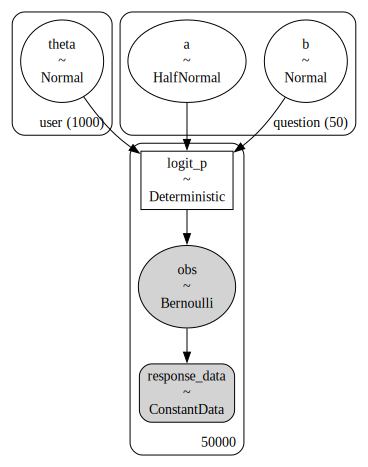

In [10]:
# 配列の項目定義(ユーザー軸と問題軸の2軸)
coords = {'user': users, 'question': questions}

# 確率モデルインスタンスの定義
model1 = pm.Model(coords=coords)

with model1:
    # 観測値の配列(1:正答　0:誤答)
    response_data = pm.ConstantData('response_data', response)

    # 能力値（受験者ごと）
    theta = pm.Normal('theta', mu=0.0, sigma=1.0, dims='user')

    # 識別力（設問ごと）
    a = pm.HalfNormal('a', sigma=1.0, dims='question')
    # 困難度（設問ごと）
    b = pm.Normal('b', mu=0.0, sigma=1.0, dims='question')

    # logit_pの計算 (2パラメータ・ロジスティックモデル（2PLM）)
    logit_p = pm.Deterministic(
        'logit_p', a[question_idx] * (theta[user_idx] - b[question_idx]))

    # ベルヌーイ分布の定義(1:正答　0:誤答)
    obs = pm.Bernoulli('obs', logit_p=logit_p, observed=response_data)

g = pm.model_to_graphviz(model1)
display(g)

### 6.3.6 サンプリングと結果分析
次のセルを実行するには相当の時間(15分程度)がかかるので注意して下さい。

#### サンプリング
``%%time``は時間を計測するためのマジックコマンド

In [11]:
%%time

with model1:
#    idata1 = pm.sample(random_seed=42)
# サンプリング関数呼び出し時のパラメータ追加
    idata1 = pm.sample(random_seed=42, nuts_sampler="numpyro")

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]




Running chain 0:   5%|▌         | 100/2000 [00:34<09:53,  3.20it/s]



Running chain 0:  10%|█         | 200/2000 [00:52<07:02,  4.26it/s]


Running chain 0:  15%|█▌        | 300/2000 [01:07<05:28,  5.17it/s]


Running chain 0:  20%|██        | 400/2000 [01:16<04:06,  6.48it/s]


Running chain 0:  30%|███       | 600/2000 [01:33<02:41,  8.68it/s]




Running chain 0:  35%|███▌      | 700/2000 [01:47<02:38,  8.20it/s]


Running chain 0:  40%|████      | 800/2000 [01:59<02:26,  8.19it/s]


Running chain 0:  45%|████▌     | 900/2000 [02:11<02:14,  8.19it/s]


Running chain 0:  50%|█████     | 1000/2000 [02:24<02:05

CPU times: total: 16min 44s
Wall time: 4min 21s


#### plot_trace関数で推論結果の確認(問題別)

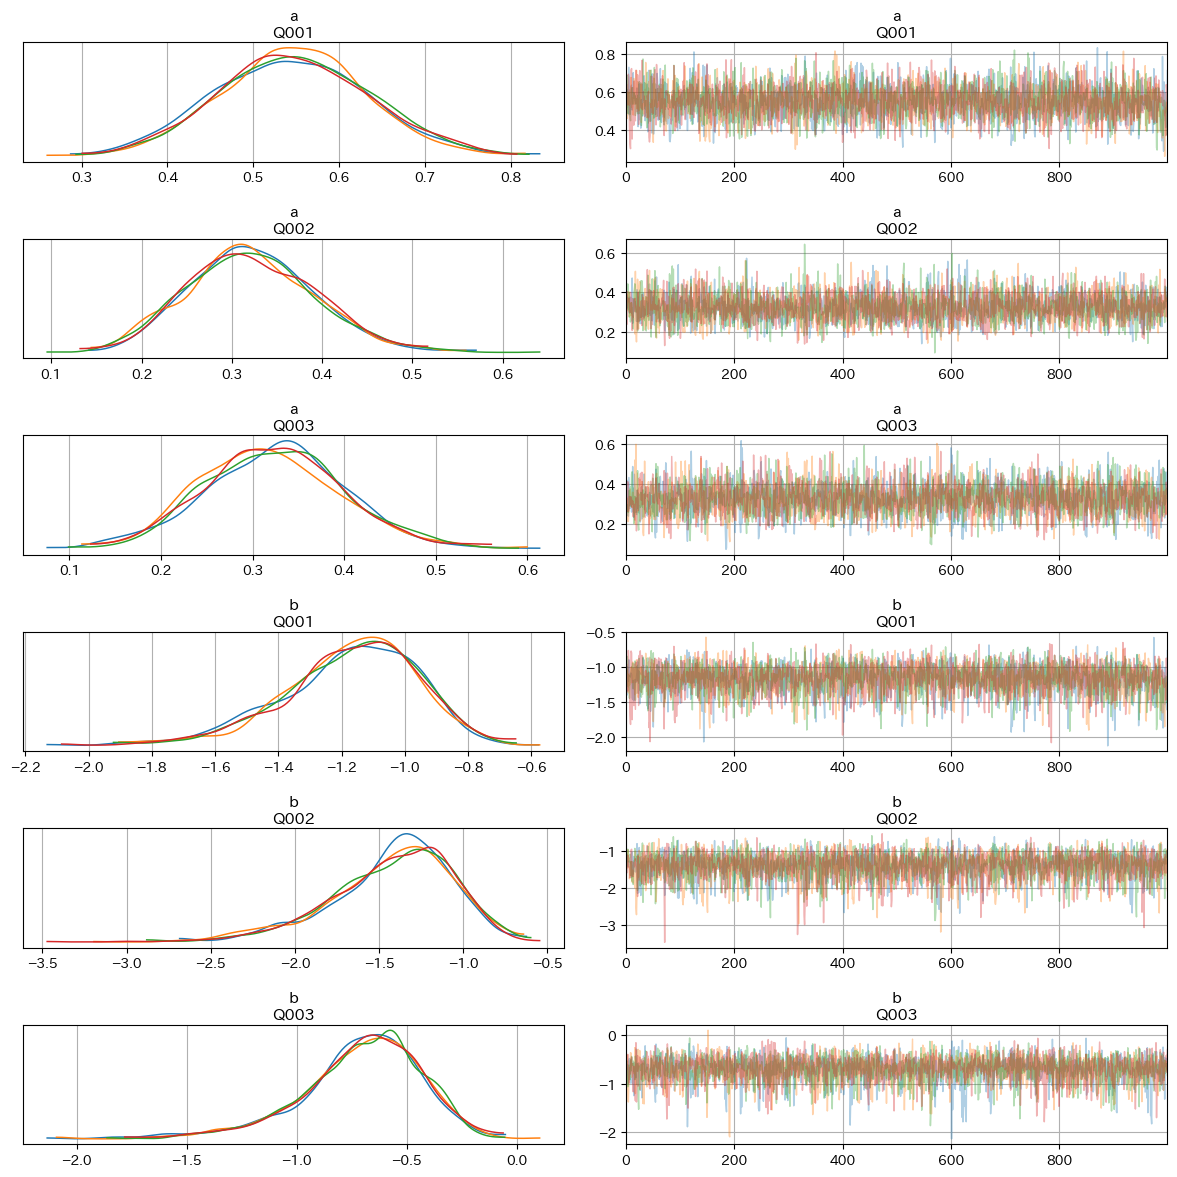

In [12]:
coords_q = {'question': ['Q001', 'Q002', 'Q003']}
az.plot_trace(
    idata1, var_names=['a', 'b'], coords=coords_q, compact=False)
plt.tight_layout();

#### plot_trace関数で推論結果の確認(受験者別)

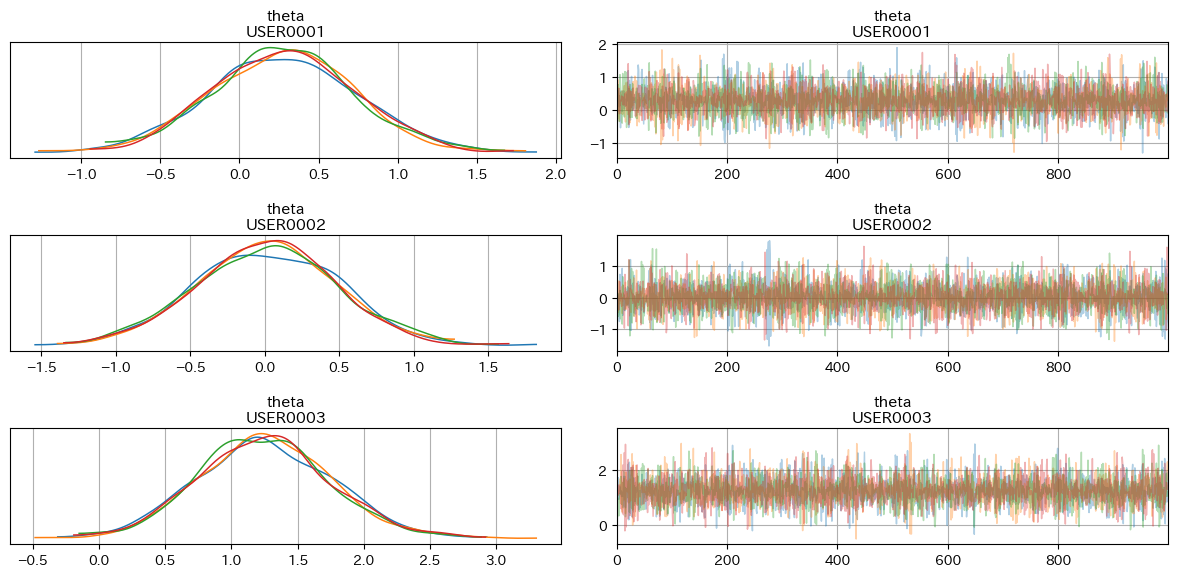

In [13]:
coords_u = {'user': ['USER0001', 'USER0002', 'USER0003']}
az.plot_trace(
    idata1, var_names=['theta'], coords=coords_u, compact=False)
plt.tight_layout();

### 6.3.7  詳細分析

#### サンプリング結果の統計分析(問題別)

In [14]:
summary_a1 = az.summary(idata1, var_names=['a'])
summary_b1 = az.summary(idata1, var_names=['b'])
display(summary_a1.head())
display(summary_b1.head())

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[Q001],0.547,0.087,0.388,0.718,0.001,0.001,4126.000,3031.000,1.000
a[Q002],0.322,0.071,0.194,0.454,0.001,0.001,4556.000,2513.000,1.000
a[Q003],0.324,0.077,0.181,0.471,0.001,0.001,3539.000,2699.000,1.000
a[Q004],0.684,0.096,0.501,0.859,0.001,0.001,4453.000,2903.000,1.000
a[Q005],0.758,0.108,0.548,0.947,0.002,0.001,3967.000,3305.000,1.000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[Q001],-1.172,0.214,-1.583,-0.796,0.003,0.003,4374.000,3059.000,1.000
b[Q002],-1.426,0.368,-2.149,-0.802,0.006,0.005,4816.000,2583.000,1.000
b[Q003],-0.706,0.273,-1.217,-0.213,0.005,0.004,4479.000,2335.000,1.000
b[Q004],-1.814,0.247,-2.259,-1.365,0.004,0.003,4713.000,3091.000,1.000
b[Q005],-2.334,0.302,-2.908,-1.802,0.005,0.004,3810.000,2988.000,1.000


#### サンプリング結果の統計分析(受験者別)
処理にやや時間がかかります。

In [15]:
summary_theta1 = az.summary(idata1, var_names=['theta'])
display(summary_theta1.head())

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[USER0001],0.278,0.455,-0.580,1.124,0.005,0.006,8270.000,2756.000,1.000
theta[USER0002],0.016,0.475,-0.904,0.898,0.005,0.009,10027.000,2947.000,1.000
theta[USER0003],1.252,0.509,0.312,2.205,0.006,0.005,8593.000,2913.000,1.000
theta[USER0004],-0.764,0.468,-1.620,0.140,0.005,0.005,9149.000,2591.000,1.000
theta[USER0005],-0.552,0.472,-1.442,0.304,0.004,0.006,12013.000,2509.000,1.000


### 6.3.8 偏差値と能力値の関係

#### 偏差値と能力値の算出

In [16]:
# 受験者ごとの正答率*100を計算し「素点」とする
df_sum1 = pd.DataFrame((df.mean(axis=1)*100), columns=['素点'])

# 素点を別変数にコピー
X = df_sum1.copy()

# 素点を偏差値のスケールに補正
X_mean, X_std = X.mean(), X.std()
X = (X-X_mean)/X_std * 10 + 50
df_sum1['偏差値'] = X

# 受験者ごとの能力値の平均を抽出
x1 = summary_theta1['mean']

# 能力値を偏差値と同じスケールに補正
x1_mean, x1_std = x1.mean(), x1.std()
x1 = (x1-x1_mean)/x1_std * 10 + 50
df_sum1['能力値'] = x1.values

# 結果の確認
display(df_sum1.head(10))

,素点,偏差値,能力値
USER0001,64.000,53.307,52.835
USER0002,58.000,48.449,49.684
USER0003,78.000,64.642,64.552
USER0004,48.000,40.352,40.301
USER0005,50.000,41.971,42.851
USER0006,62.000,51.687,49.082
USER0007,52.000,43.591,41.684
USER0008,54.000,45.210,44.920
USER0009,60.000,50.068,49.154
USER0010,62.000,51.687,49.166


#### 偏差値との能力値の関係可視化

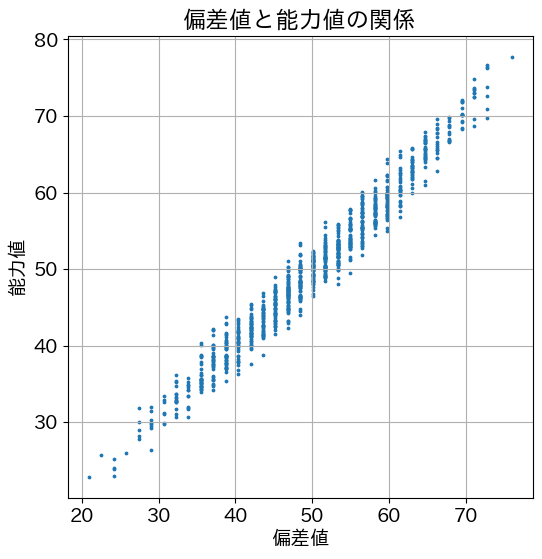

In [17]:
plt.scatter(df_sum1['偏差値'], df_sum1['能力値'], s=3)
plt.title('偏差値と能力値の関係')
plt.xlabel('偏差値')
plt.ylabel('能力値');

### 6.3.9 同じ偏差値の受験者間の能力値の違い分析

#### 同じ素点(偏差値)で能力値の高い受験者と低い受験者を抽出

In [18]:
# 1. 素点62点(偏差値51.69)の受験者を抽出
df_62_1 = df_sum1.query('素点==62')
print(f'素点62点の受験者数: {len(df_62_1)}\n')

# 2. 一番能力値の低い受験者を抽出
argmin1 = df_62_1['能力値'].values.argmin()
print('素点62点で一番能力値の低い受験者\n', df_62_1.iloc[argmin1], '\n')

# 3. 一番能力値の高い受験者を抽出
argmax1 = df_62_1['能力値'].values.argmax()
print('素点62点で一番能力値の高い受験者\n', df_62_1.iloc[argmax1])

素点62点の受験者数: 59

素点62点で一番能力値の低い受験者
 素点    62.000
偏差値   51.687
能力値   48.493
Name: USER0463, dtype: float64 

素点62点で一番能力値の高い受験者
 素点    62.000
偏差値   51.687
能力値   56.168
Name: USER0064, dtype: float64


#### 二人の受験者が正解した問題の平均困難度を計算

In [19]:
# 二人の受験者の問題ごとの正答を抽出
w1 = df.loc[['USER0463','USER0064']]
display(w1)
w2 = w1.sum(axis=1)
print(f'w1のshape: {w1.shape}\n正解数:\n{w2}\n')

# 問題別の平均困難度
b_mean1 = az.summary(
    idata1, var_names=['b'])['mean'].values.reshape(1,-1)
print(b_mean1)
print(f'b_meanのshape: {b_mean1.shape}\n')

# 二人の受験者が解いた問題の平均困難度
w3 = (w1 * b_mean1).sum(axis=1)/w2.iloc[0]
print(w3)

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
USER0463,0,0,1,1,1,1,1,1,0,0,1,0,1,0,0,0,1,1,1,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,1,1,1,1,1,0,0,1,1
USER0064,1,0,1,1,1,0,1,0,0,0,0,1,1,0,1,1,1,1,1,0,0,1,1,0,1,0,1,1,0,1,0,0,1,1,1,0,1,1,1,0,0,1,1,0,1,1,0,1,1,1


w1のshape: (2, 50)
正解数:
USER0463    31
USER0064    31
dtype: int64

[[-1.172 -1.426 -0.706 -1.814 -2.334 -1.413 -2.118 -1.844  1.250  1.287
  -0.580 -1.954 -0.678  0.287 -0.089  0.330  0.073 -2.370 -1.764 -1.033
  -1.574 -1.851  1.350 -1.498  1.293  1.072 -1.691 -0.290 -1.942 -2.202
  -0.182  0.010 -0.912 -0.643 -1.266  0.267 -1.561 -1.409 -2.084  0.601
  -0.066 -1.300 -2.857 -1.386  0.615  0.455  0.531 -1.753 -2.008 -1.877]]
b_meanのshape: (1, 50)

USER0463   -1.208
USER0064   -1.116
dtype: float64


#### 二人の受験者のサンプル値ごとの能力値の分布

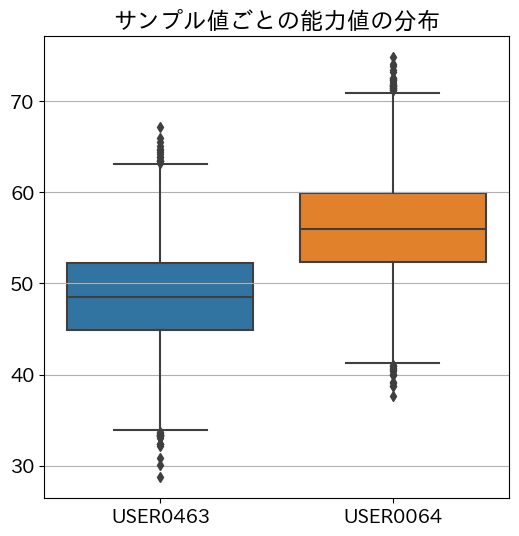

In [20]:
# USER0463とUSER0064の能力値のサンプルデータを抽出
w1 = idata1['posterior'].data_vars[
    'theta'].loc[:,:,['USER0463','USER0064']].values

# 軸の順番を入れ替え後、受験者を第一要素とする行列に変換
w2 = w1.transpose().reshape(2, -1)

# 能力値のスケール変更
w3 = (w2 - x1_mean)/x1_std * 10 + 50

# 受験者を列名とするデータフレームに変換
df_w3 = pd.DataFrame(w3.T, columns=['USER0463', 'USER0064'])

# Seabornのboxplot関数で可視化
sns.boxplot(df_w3)
plt.title('サンプル値ごとの能力値の分布');

### コラム　変分推論法の利用
参考リンク https://www.pymc.io/projects/examples/en/latest/variational_inference/variational_api_quickstart.html

#### 確率モデル定義

In [21]:
# 配列の項目定義(ユーザー軸と問題軸の２軸)
coords = {'user': users, 'question': questions}

# 確率モデルインスタンスの定義
model2 = pm.Model(coords=coords)

with model2:
    # 観測値の配列(1:正答　0:誤答)
    response_data = pm.ConstantData('response_data', response)

    # 能力値（受験者ごと）
    theta = pm.Normal('theta', mu=0.0, sigma=1.0, dims='user')

    # 識別力（設問ごと）
    a = pm.HalfNormal('a', sigma=1.0, dims='question')
    # 困難度（設問ごと）
    b = pm.Normal('b', mu=0.0, sigma=1.0, dims='question')

    # logit_pの計算 (2パラメータ・ロジスティックモデル（2PLM）)
    logit_p = pm.Deterministic(
        'logit_p', a[question_idx] * (theta[user_idx] - b[question_idx]))

    # ベルヌーイ分布の定義(1:正答　0:誤答)
    obs = pm.Bernoulli('obs', logit_p=logit_p, observed=response_data)

#### 変分推論法のfit関数呼び出し

In [22]:
%%time

with model2:
    mean_field = pm.fit(method=pm.ADVI(), n=20000,
        obj_optimizer=pm.adam())

Finished [100%]: Average Loss = 30,872


CPU times: total: 3min 56s
Wall time: 3min 57s


#### 変分推論法の収束確認

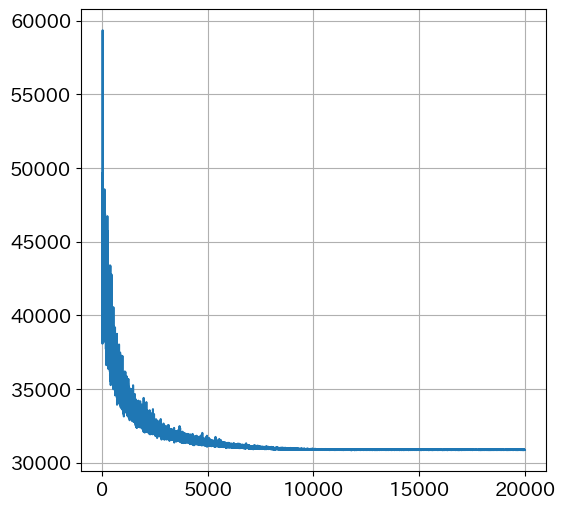

In [23]:
plt.plot(mean_field.hist);

#### 変分推論法のサンプリング

In [24]:
%%time

idata2 = mean_field.sample(2000)

CPU times: total: 1.89 s
Wall time: 1.93 s


#### 偏差値と能力値の算出

In [25]:
summary_theta2 = az.summary(idata2, var_names=['theta'])

# 本編の実習で作った変数df_sumをコピーする
df_sum2 = df_sum1.copy()

# 受験者ごとの能力値の平均を抽出
x2 = summary_theta2['mean'].values

# 能力値を偏差値と同じスケールに補正
x2_mean, x2_std = x2.mean(), x2.std()
x2 = (x2-x2_mean)/x2_std * 10 + 50
df_sum2['能力値2'] = x2

# 結果の確認
display(df_sum2.head(10))

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,素点,偏差値,能力値,能力値2
USER0001,64.000,53.307,52.835,52.508
USER0002,58.000,48.449,49.684,49.584
USER0003,78.000,64.642,64.552,64.386
USER0004,48.000,40.352,40.301,40.655
USER0005,50.000,41.971,42.851,42.756
USER0006,62.000,51.687,49.082,48.903
USER0007,52.000,43.591,41.684,41.717
USER0008,54.000,45.210,44.920,44.964
USER0009,60.000,50.068,49.154,49.178
USER0010,62.000,51.687,49.166,49.166


#### 二人の受験者のサンプル値ごとの能力値の分布

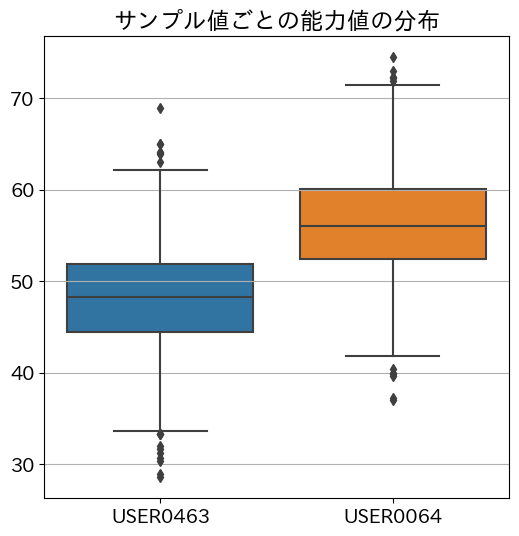

In [26]:
# USER0463とUSER0064の能力値のサンプルデータを抽出
w1 = idata2['posterior'].data_vars[
    'theta'].loc[:,:,['USER0463','USER0064']].values

# 軸の順番を入れ替え後、受験者を第一要素とする行列に変換
w2 = w1.transpose().reshape(2, -1)

# 能力値のスケール変更
w3 = (w2 - x2_mean)/x2_std * 10 + 50

# 受験者を列名とするデータフレームに変換
df_w3 = pd.DataFrame(w3.T, columns=['USER0463', 'USER0064'])

# Seabornのboxplot関数で可視化
sns.boxplot(df_w3)
plt.title('サンプル値ごとの能力値の分布');

#### バージョンの確認

In [27]:
#!pip install watermark | tail -n 1
%load_ext watermark
%watermark --iversions

seaborn            : 0.12.2
pymc               : 5.11.0
numpy              : 1.26.4
matplotlib         : 3.8.3
pandas             : 2.2.1
japanize_matplotlib: 1.1.3
arviz              : 0.17.1

